Data Cleaning:

Handled missing or inconsistent values in key fields (e.g., time gaps, geohash lengths).

Converted boolean fields (like device_change_flag) into binary format (0/1).

Feature Scaling:

Normalized numerical features such as sim_swap_time_gap_minutes and otp_and_sim_change_geo_hash_length using MinMaxScaler.

Feature Enrichment:

Created new derived features:

time_urgency_score: Indicates how quickly OTP was requested after a SIM swap (higher = more suspicious).

identity_shift_score: Sum of device/SIM identity changes (higher = greater identity alteration).

geo_risk_score: Inverse of geohash similarity (higher = greater physical distance between SIM swap and OTP).

In [3]:
# STEP 1: DATA NORMALIZATION AND ENRICHMENT

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Load your dataset
df = pd.read_csv("sim_swap_fraud_dataset_10000.csv")

# --- HANDLE MISSING OR INCONSISTENT VALUES ---
df.fillna({
    'sim_swap_time_gap_minutes': df['sim_swap_time_gap_minutes'].median(),
    'otp_and_sim_change_geo_hash_length': df['otp_and_sim_change_geo_hash_length'].median()
}, inplace=True)

# Replace boolean-like strings if needed
bool_cols = ['sim_swap_flag', 'device_change_flag', 'sim_type_change_flag',
             'imsi_change_flag', 'iccid_change_flag']
for col in bool_cols:
    if df[col].dtype == object:
        df[col] = df[col].map({'true': True, 'false': False})
    df[col] = df[col].astype(int)  # convert to 0/1

# --- NORMALIZE NUMERICAL COLUMNS ---
scaler = MinMaxScaler()
df[['sim_swap_time_gap_minutes', 'otp_and_sim_change_geo_hash_length']] = scaler.fit_transform(
    df[['sim_swap_time_gap_minutes', 'otp_and_sim_change_geo_hash_length']]
)

# --- DERIVE NEW FEATURES ---
# e.g., time urgency score (inverse of time gap)
df['time_urgency_score'] = 1 - df['sim_swap_time_gap_minutes']

# e.g., combined identity shift score
df['identity_shift_score'] = df[['device_change_flag', 'sim_type_change_flag',
                                 'imsi_change_flag', 'iccid_change_flag']].sum(axis=1)

# e.g., geo_risk_score (inverse of geohash similarity)
df['geo_risk_score'] = 1 - df['otp_and_sim_change_geo_hash_length']

# Final check
print(df.head())


   sim_swap_time_gap_minutes  sim_swap_flag  device_change_flag  \
0                   0.005854              0                   0   
1                   0.000000              1                   0   
2                   0.000000              0                   0   
3                   0.000099              1                   0   
4                   1.000000              0                   0   

   sim_type_change_flag  imsi_change_flag  iccid_change_flag  \
0                     1                 0                  1   
1                     0                 0                  1   
2                     0                 0                  1   
3                     0                 1                  0   
4                     0                 0                  1   

   otp_and_sim_change_geo_hash_length  time_urgency_score  \
0                               0.750            0.994146   
1                               0.000            1.000000   
2                            

**Step 02**
Train an unsupervised model to learn the structure of “normal” SIM usage patterns and flag unusual behaviors as anomalies.
________________________________________
🧠 Options for Unsupervised Models:
1.	Isolation Forest (recommended to start)
o	Efficient for large datasets
o	Doesn't require prior scaling of features
o	Detects outliers by randomly partitioning data
2.	Local Outlier Factor (LOF)
o	Detects outliers by comparing local density
3.	Autoencoder
o	Learns to reconstruct normal data; high reconstruction error = anomaly
________________________________________
🛠️ Implementation Plan (Isolation Forest Example):
1.	Select feature columns (including your enriched ones)
2.	Train the IsolationForest model
3.	Predict anomaly scores and flags


anomaly_flag
0    9506
1     494
Name: count, dtype: int64
    sim_swap_time_gap_minutes  sim_swap_flag  device_change_flag  \
4                    1.000000              0                   0   
9                    1.000000              0                   0   
12                   0.142772              0                   0   
19                   1.000000              0                   0   
52                   1.000000              0                   1   

    sim_type_change_flag  imsi_change_flag  iccid_change_flag  \
4                      0                 0                  1   
9                      0                 1                  0   
12                     0                 1                  1   
19                     1                 0                  0   
52                     0                 0                  0   

    otp_and_sim_change_geo_hash_length  time_urgency_score  \
4                                0.875            0.000000   
9                

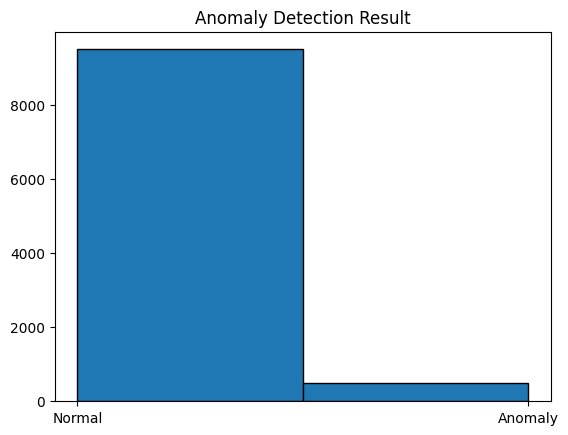

In [4]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt

# Step 1: Select features for training
feature_columns = [
    'sim_swap_time_gap_minutes',
    'device_change_flag',
    'sim_type_change_flag',
    'imsi_change_flag',
    'iccid_change_flag',
    'otp_and_sim_change_geo_hash_length',
    'time_urgency_score',
    'identity_shift_score',
    'geo_risk_score'
]

X = df[feature_columns]

# Step 2: Train Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df['anomaly_score'] = iso_forest.fit_predict(X)
df['anomaly_flag'] = df['anomaly_score'].apply(lambda x: 1 if x == -1 else 0)

# Step 3: Analyze results
print(df['anomaly_flag'].value_counts())
print(df[df['anomaly_flag'] == 1].head())

# Optional: Visualize score distribution
plt.hist(df['anomaly_flag'], bins=2, edgecolor='black')
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.title("Anomaly Detection Result")
plt.show()


**Step 3**
Scoring and Ranking Anomalies
🎯 Objective
Prioritize suspicious activity based on the severity of anomaly patterns identified by the model. This helps analysts focus on the most likely fraud cases first.

🔍 How It Works
1. Decision Function (Anomaly Score)
Most unsupervised models like IsolationForest provide a decision function:

This returns a raw anomaly score for each record.

The score indicates how isolated (anomalous) a point is compared to the general data.

In Isolation Forest, lower scores = more anomalous.

2. Interpretation of Scores
Scores range from negative (anomalous) to positive (normal).

You can sort the data to bring the most suspicious records to the top.

3. Ranking
Sort the dataset by anomaly score in ascending order.

Add a rank column to assign each record a position.

Optionally assign risk categories (e.g., Top 5% = High Risk).

📊 Outputs to Generate
Column	Description
anomaly_score	Raw score from decision_function()
anomaly_flag	Binary flag from .predict()
anomaly_rank	Rank based on anomaly severity (1 = worst)
risk_level	Categorical risk label (High, Medium, Low)

In [5]:
# Step 3: Scoring and Ranking Anomalies

# Get anomaly scores (higher negative = more anomalous)
df['raw_anomaly_score'] = iso_forest.decision_function(X)

# Rank anomalies: lower score = more suspicious
df['anomaly_rank'] = df['raw_anomaly_score'].rank(method='first', ascending=True).astype(int)

# Optional: Convert rank into risk categories (Top 5% = High, Next 10% = Medium, Rest = Low)
quantiles = df['anomaly_rank'].quantile([0.05, 0.15])
def assign_risk(rank):
    if rank <= quantiles[0.05]:
        return 'High'
    elif rank <= quantiles[0.15]:
        return 'Medium'
    else:
        return 'Low'

df['risk_level'] = df['anomaly_rank'].apply(assign_risk)

# View top suspicious records
print(df.sort_values('anomaly_rank').head(10))

# Optional: Save to CSV for analyst review
df.to_csv("scored_sim_swap_anomalies.csv", index=False)


      sim_swap_time_gap_minutes  sim_swap_flag  device_change_flag  \
4051                        1.0              0                   1   
8143                        1.0              0                   1   
5449                        1.0              0                   1   
5297                        1.0              0                   1   
295                         1.0              0                   1   
9456                        1.0              0                   1   
6321                        1.0              0                   1   
4618                        1.0              0                   1   
194                         1.0              0                   1   
8786                        1.0              0                   1   

      sim_type_change_flag  imsi_change_flag  iccid_change_flag  \
4051                     1                 0                  1   
8143                     1                 0                  1   
5449                     1  

**Step 4: Expert or Heuristic Validation**
🎯 Objective
Refine anomaly detection results by:

Applying domain knowledge and business logic.

Identifying true positives among flagged anomalies.

Strengthening weak supervision when ground-truth labels are unavailable.

🧠 Two-Pronged Approach
A. Domain Heuristics
Define business rules based on expert intuition and known fraud patterns. Example:

Rule Description	Condition
OTP requested within 5 mins of SIM swap	sim_swap_time_gap_minutes < 5
Device, SIM type, and ICCID all changed	identity_shift_score ≥ 3
Location mismatch	geo_risk_score > 0.6

You can combine these into a composite heuristic score.

B. Expert Review (Optional)
If analysts are available:

Share top 1–2% anomalies (risk_level = High)

Manually inspect behavior logs, user records, geo data



In [6]:
# Create a heuristic flag: likely fraud if urgent + identity shift + far location
df['heuristic_fraud_flag'] = (
    (df['time_urgency_score'] > 0.8) &
    (df['identity_shift_score'] >= 3) &
    (df['geo_risk_score'] > 0.6)
).astype(int)

# Summary
print("Heuristic Fraud Detections:", df['heuristic_fraud_flag'].sum())
print(df[df['heuristic_fraud_flag'] == 1][['sim_swap_time_gap_minutes', 'identity_shift_score', 'geo_risk_score', 'risk_level']].head())

# Save for optional expert review
df.to_csv("heuristically_validated_anomalies.csv", index=False)


Heuristic Fraud Detections: 1267
    sim_swap_time_gap_minutes  identity_shift_score  geo_risk_score risk_level
8                    0.000397                     3           0.625        Low
14                   0.000000                     3           0.750        Low
16                   0.000000                     3           1.000     Medium
17                   0.000397                     3           0.625        Low
18                   0.000397                     3           0.750        Low


**Step 5: Visualization and Reporting**
🎯 Objective
Use visual tools to:

Understand anomaly distributions.

Compare fraud-like vs. normal behavior.

Communicate insights to stakeholders clearly.

📊 Visualization Goals
Visualization	Purpose
Histogram of anomaly flags	View normal vs. flagged ratios
Box plots	Compare feature values between normal and anomalies
Correlation heatmap	Understand relationships between risk features
Time-based trends (if timestamp exists)	Detect suspicious activity bursts

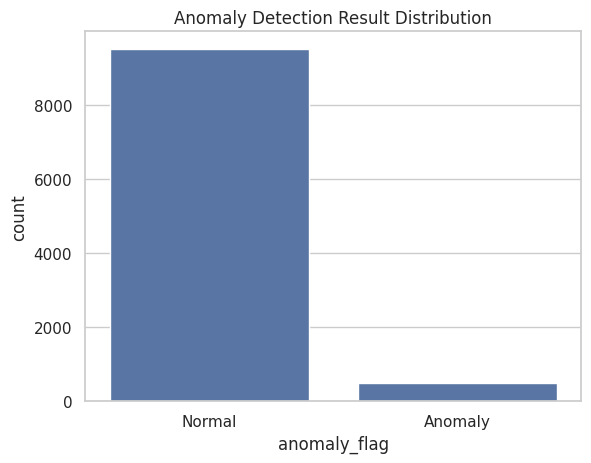

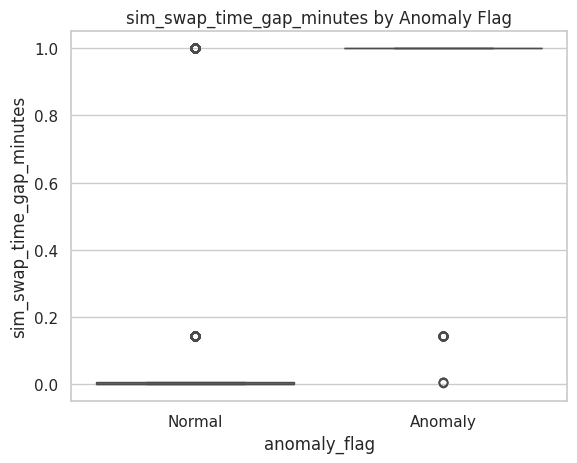

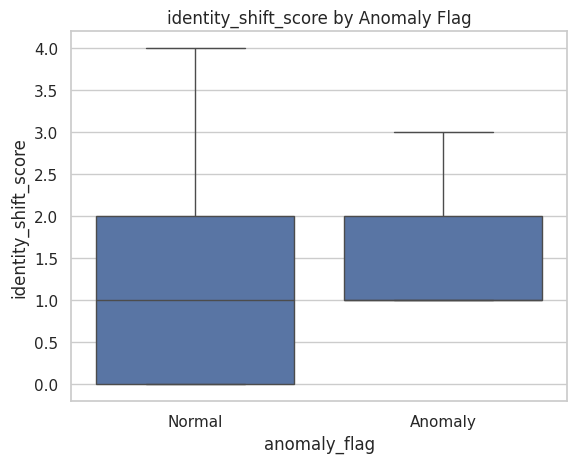

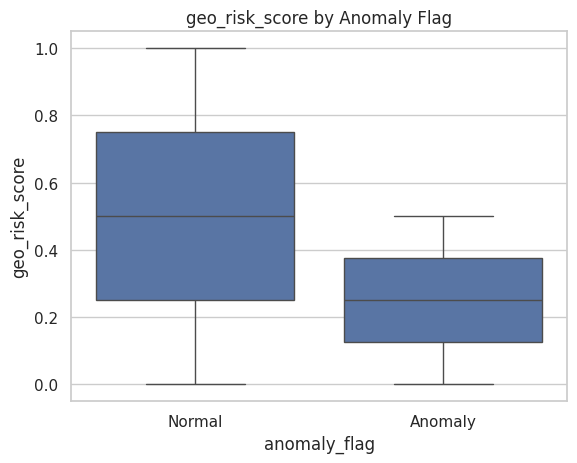

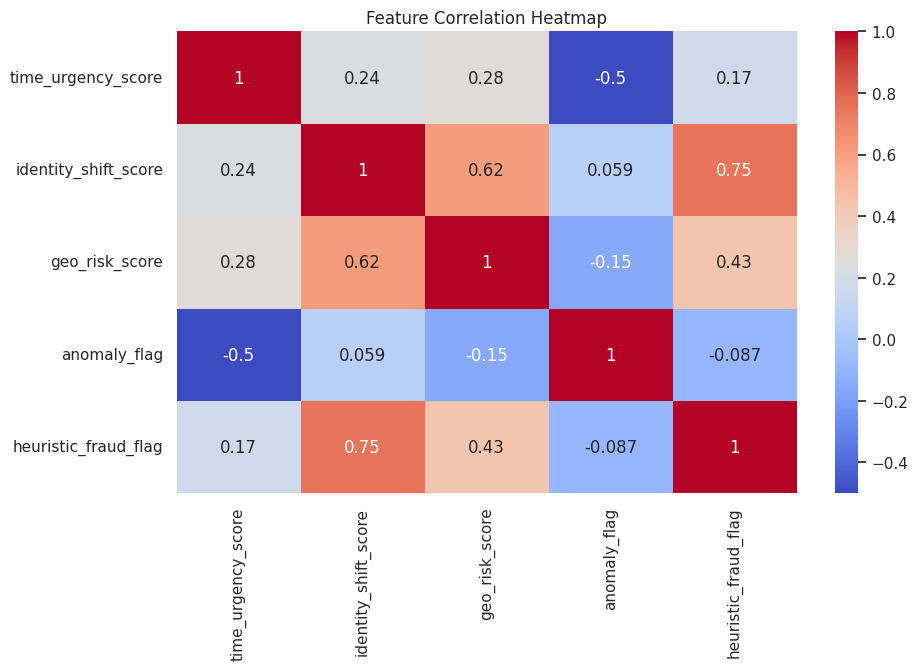

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set theme
sns.set(style="whitegrid")

# 1. Histogram of anomaly flags
sns.countplot(data=df, x='anomaly_flag')
plt.title("Anomaly Detection Result Distribution")
plt.xticks([0, 1], ['Normal', 'Anomaly'])
plt.show()

# 2. Boxplot: feature distributions by anomaly
features_to_plot = ['sim_swap_time_gap_minutes', 'identity_shift_score', 'geo_risk_score']
for feature in features_to_plot:
    sns.boxplot(data=df, x='anomaly_flag', y=feature)
    plt.title(f"{feature} by Anomaly Flag")
    plt.xticks([0, 1], ['Normal', 'Anomaly'])
    plt.show()

# 3. Heatmap of correlations
plt.figure(figsize=(10, 6))
sns.heatmap(df[[
    'time_urgency_score', 'identity_shift_score', 'geo_risk_score',
    'anomaly_flag', 'heuristic_fraud_flag'
]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.show()


**Step 6: Feedback Loop & Model Refinement**
🎯 Objective
Improve the anomaly detection model iteratively by:

Learning from expert feedback or high-confidence flags.

Enhancing model precision over time without needing full labels.

Transitioning toward semi-supervised learning.

🔁 Strategies for Model Refinement
A. Use Heuristic Flags as Pseudo-Labels
Treat high-confidence heuristic_fraud_flag = 1 as provisional fraud cases to:

Evaluate model accuracy

Fine-tune thresholds

Train a weakly-supervised classifier (e.g., logistic regression)

B. Incorporate Analyst Feedback
Review top 100 anomalies

Add an expert_label column (1 = fraud, 0 = safe)

Re-train models with this small labeled subset as validation or guidance

C. Model Tuning
Adjust IsolationForest contamination parameter

Explore model ensembles (e.g., combine Autoencoder + IsolationForest)

D. Feature Importance Analysis
Use model-based importance scoring (e.g., SHAP values or tree feature importances) to:

Identify top predictive signals

Remove noisy or irrelevant features

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Use heuristic fraud flag as pseudo-label
X_supervised = df[feature_columns]
y_pseudo = df['heuristic_fraud_flag']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_supervised, y_pseudo, test_size=0.2, random_state=42)

# Logistic regression for interpretability
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1751
           1       0.98      1.00      0.99       249

    accuracy                           1.00      2000
   macro avg       0.99      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



**Step 7: Deployment & Monitoring**

🎯 Objective
Deploy the fraud detection model in a production or near-real-time environment and monitor its performance to ensure reliability and timely detection.

🚀 Deployment Options
Method	Use Case
FastAPI / Flask	Lightweight APIs for real-time inference
Docker	Containerize your app for consistent deployment
Streamlit	Interactive dashboards for fraud analysts
Airflow / Cron	Schedule batch predictions regularly
MLflow / DVC	Model versioning and experiment tracking

In [9]:
import joblib

joblib.dump(iso_forest, 'isolation_forest_model.pkl')


['isolation_forest_model.pkl']

In [10]:
from fastapi import FastAPI
import joblib
import pandas as pd

app = FastAPI()
model = joblib.load("isolation_forest_model.pkl")

@app.post("/predict/")
def predict(data: dict):
    df = pd.DataFrame([data])
    score = model.decision_function(df)
    flag = model.predict(df)
    return {"anomaly_score": float(score[0]), "anomaly_flag": int(flag[0])}


C. Run it Locally or in the Cloud
bash
Copy
Edit
uvicorn main:app --reload
D. Monitoring Tips
Log daily predictions and anomaly counts.

Track false positives flagged by analysts.

Monitor model drift with SHAP or feature distribution shifts.

📈 Next Steps
Set up a dashboard (Grafana/Power BI/Streamlit).

Implement alerting for high anomaly scores.

Automate periodic retraining using new feedback.

✅ Test the Model in Colab with Sample Records

In [19]:
# Step 1: Define a Test Record

# Define a sample test record (same structure as feature_columns)
test_record = {
    'sim_swap_time_gap_minutes': 200000,
    'device_change_flag': 0,
    'sim_type_change_flag': 0,
    'imsi_change_flag': 0,
    'iccid_change_flag': 0,
    'otp_and_sim_change_geo_hash_length': 0.2,
    'time_urgency_score': 0.99,
    'identity_shift_score': 4,
    'geo_risk_score': 0.8
}

# Convert to DataFrame
test_df = pd.DataFrame([test_record])

In [20]:
 # Step 2: Predict with Trained Model

 # Predict anomaly score and flag
test_score = iso_forest.decision_function(test_df)
test_flag = iso_forest.predict(test_df)

print("Anomaly Score:", test_score[0])
print("Anomaly Flag (1 = normal, -1 = anomaly):", test_flag[0])

Anomaly Score: 0.010008062223776704
Anomaly Flag (1 = normal, -1 = anomaly): 1


In [21]:
def enrich_input(raw):
    enriched = raw.copy()

    # Normalize sim_swap_time_gap_minutes (assuming 0 to 10080 range)
    enriched['time_urgency_score'] = 1 - min(raw['sim_swap_time_gap_minutes'], 10080) / 10080

    # Sum identity flags
    enriched['identity_shift_score'] = sum([
        raw['device_change_flag'],
        raw['sim_type_change_flag'],
        raw['imsi_change_flag'],
        raw['iccid_change_flag']
    ])

    # Normalize geo risk (assuming 0 to 1, invert geohash similarity)
    enriched['geo_risk_score'] = 1 - raw['otp_and_sim_change_geo_hash_length']

    return enriched

In [34]:
raw_input = {
    'sim_swap_time_gap_minutes': 100,
    'device_change_flag': 1,
    'sim_type_change_flag': 0,
    'imsi_change_flag': 0,
    'iccid_change_flag': 0,
    'otp_and_sim_change_geo_hash_length': 0.2
}

enriched_input = enrich_input(raw_input)
test_df = pd.DataFrame([enriched_input])

# Now predict
score = iso_forest.decision_function(test_df)
flag = iso_forest.predict(test_df)

print("Anomaly Score:", score[0])
print("Anomaly Flag:", flag[0])


Anomaly Score: 0.030296542408945082
Anomaly Flag: 1


In [35]:
def rule_based_risk_assessment(row):
    if row['device_change_flag'] == 1 and row['geo_risk_score'] > 0.6 and row['time_urgency_score'] > 0.9:
        return 'High'
    elif row['identity_shift_score'] >= 3:
        return 'High'
    elif row['anomaly_flag'] == -1:
        return 'Medium'
    else:
        return 'Low'

In [36]:
risk = rule_based_risk_assessment(enriched_input)
print("Final Risk Assessment:", risk)

Final Risk Assessment: High
